# TODO

- Weighted Cross Entropy Lossのチューニング

# Setting

In [1]:
import sys

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

root_dir = "../../"
if root_dir not in sys.path:
    sys.path.append(root_dir)
from modules import config as cfg
from modules import utils, preprosess, training, predict, metrics

exp = "exp14"
utils.set_seed(cfg.Params.seed)

# Read data

In [2]:
train, test, submit = utils.get_data(debug_mode=False)

# Preprocessing

## Split fold

In [3]:
train = preprosess.assign_stratified_k_fold(train, "MIS_Status")

## Convert

In [4]:
# 地名を座標に変換
train = preprosess.convert_to_latlon(train)
test  = preprosess.convert_to_latlon(test)

# testのBankStateの"PR"はtrainにないため，一番多いCAに変換
test = test.with_columns(pl.col("BankState").str.replace("PR", "CA"))

# DisbursementDateとApprovalDateをYear(数値)に変換
cols  = ["DisbursementDate", "ApprovalDate"]
train = preprosess.convert_date_to_year(train, cols)
test  = preprosess.convert_date_to_year(test, cols)

# 金額データの数値化
cols  = ["DisbursementGross",  "GrAppv", "SBA_Appv"]
train = preprosess.convert_money_data(train, cols)
test  = preprosess.convert_money_data(test, cols)

# 一致しているか
eqs = [
    ["State", "BankState"],
]
train = preprosess.add_eq(train, eqs)
test  = preprosess.add_eq(test, eqs)

# 差の計算
diffs = [
    ["DisbursementGross", "GrAppv"],   # 支払われた額 vs 銀行承認額
    ["DisbursementGross", "SBA_Appv"], # 支払われた額 vs SBA承認額
    ["GrAppv", "SBA_Appv"],            # 銀行承認額 vs SBA承認額
]
train = preprosess.add_diff(train, diffs)
test  = preprosess.add_diff(test, diffs)

# DisbursementDateとApprovalDateの差を計算
train = preprosess.add_diff_disbursement_with_approval(train)
test  = preprosess.add_diff_disbursement_with_approval(test)

# 割合の計算
divs = [
    # ["DisbursementGross", "Term"],
    ["GrAppv", "Term"],
    ["SBA_Appv", "Term"],
    ["NoEmp", "Term"],
    # ["DisbursementGross", "NoEmp"],
    # ["GrAppv", "NoEmp"],
    # ["SBA_Appv", "NoEmp"],
    ["DisbursementGross_GrAppv_diff", "Term"],
    ["DisbursementGross_SBA_Appv_diff", "Term"],
    ["GrAppv_SBA_Appv_diff", "Term"],
    # ["DisbursementGross_GrAppv_diff", "NoEmp"],
    # ["DisbursementGross_SBA_Appv_diff", "NoEmp"],
    # ["GrAppv_SBA_Appv_diff", "NoEmp"]
]
train = preprosess.add_div(train, divs)
test  = preprosess.add_div(test, divs)

# Sectorを職業別にする
train = preprosess.unify_same_sector(train)
test  = preprosess.unify_same_sector(test)

## Target encoding

In [5]:
cols = [
    # "Sector",
    "UrbanRural",
    "RevLineCr",
    "LowDoc",
    "FranchiseCode",
]
target_col = "MIS_Status"
train, test = preprosess.target_encoding(train, test, cols)

## Label encoding
CVによるtarget encodingでは同じカテゴリカル変数に異なる値が割り当てられるのでlabel encodingを併用する

In [6]:
cols = ["RevLineCr", "LowDoc"]
train, test = preprosess.label_encoding(train, test, cols)

# Drop columns

In [7]:
# 不要なカラムの削除
del_cols = [
    # 地名系
    "City",
    "State",
    "BankState",
    # d-b-y系
    "DisbursementDate",
    "ApprovalDate",
    "ApprovalFY",
    # ラベルエンコーディング済み
    "RevLineCr",
    "LowDoc",
]
train = train.drop(del_cols)
test  = test.drop(del_cols)

# Training + Tuning

In [9]:
lgb_params = {
    'objective': 'binary',
    'metric': 'custom',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}

alpha_li = [i / 100 for i in range(1, 100, 5)]

threshold = 0.5
results_df = pl.DataFrame([
        pl.Series("alpha", [], dtype=pl.Float64),
        pl.Series("score", [], dtype=pl.Float64)
])
for alpha in alpha_li:
    oof, models = training.fit_lgbm_wcel(train, lgb_params=lgb_params, alpha=alpha)
    oof_truth = train[cfg.Cols.target].to_numpy()
    oof_hat = predict.predict_class(oof, threshold=threshold)
    cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
    results_df = results_df.vstack(pl.DataFrame({"alpha": [alpha], "score": [cv_score]}))

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5177
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.01: 0.0142871	valid_1's WCE_alpha0.01: 0.0554026
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.01: 0.0142871	valid_1's WCE_alpha0.01: 0.0554026
Time:  3.581[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.01: 0.0139349	valid_1's WCE_alpha0.01: 0.0564103
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.01: 0.0139349	valid_1's WCE_alpha0.01: 0.0564103
Time:  4.324[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011446 seconds.
You can set `force_col_wise=true` to remove the ov

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.06: 0.0500317	valid_1's WCE_alpha0.06: 0.093887
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.06: 0.0500317	valid_1's WCE_alpha0.06: 0.093887
Time:  2.684[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014432 seconds.
You can set `force_col_wise=true` to remove the over

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.11: 0.071518	valid_1's WCE_alpha0.11: 0.122835
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.11: 0.071518	valid_1's WCE_alpha0.11: 0.122835
Time:  2.581[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010432

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.16: 0.0878009	valid_1's WCE_alpha0.16: 0.142916
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.16: 0.0878009	valid_1's WCE_alpha0.16: 0.142916
Time:  3.277[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009933 seconds.
You can set `force_col_wise=true` to remove the over

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.21: 0.0994415	valid_1's WCE_alpha0.21: 0.159048
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.21: 0.0994415	valid_1's WCE_alpha0.21: 0.159048
Time:  2.719[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008372 seconds.
You can set `force_col_wise=true` to remove the over

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.26: 0.109869	valid_1's WCE_alpha0.26: 0.174092
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.26: 0.109869	valid_1's WCE_alpha0.26: 0.174092
Time:  2.696[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011397

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.31: 0.119866	valid_1's WCE_alpha0.31: 0.186442
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.31: 0.119866	valid_1's WCE_alpha0.31: 0.186442
Time:  2.598[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011684 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.36: 0.126057	valid_1's WCE_alpha0.36: 0.197769
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.36: 0.126057	valid_1's WCE_alpha0.36: 0.197769
Time:  2.317[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009651

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.41: 0.135285	valid_1's WCE_alpha0.41: 0.207495
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.41: 0.135285	valid_1's WCE_alpha0.41: 0.207495
Time:  3.504[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010718 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.46: 0.140514	valid_1's WCE_alpha0.46: 0.216118
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.46: 0.140514	valid_1's WCE_alpha0.46: 0.216118
Time:  2.543[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009526 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.51: 0.146527	valid_1's WCE_alpha0.51: 0.224551
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.51: 0.146527	valid_1's WCE_alpha0.51: 0.224551
Time:  2.651[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014726 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.56: 0.152588	valid_1's WCE_alpha0.56: 0.233921
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.56: 0.152588	valid_1's WCE_alpha0.56: 0.233921
Time:  2.752[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008757 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.61: 0.157512	valid_1's WCE_alpha0.61: 0.237989
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.61: 0.157512	valid_1's WCE_alpha0.61: 0.237989
Time:  2.552[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009201 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.66: 0.161321	valid_1's WCE_alpha0.66: 0.249577
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.66: 0.161321	valid_1's WCE_alpha0.66: 0.249577
Time:  3.874[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009942 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.71: 0.165865	valid_1's WCE_alpha0.71: 0.2511
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.71: 0.165865	valid_1's WCE_alpha0.71: 0.2511
Time:  2.676[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009921 seconds.
You can set `force_col_wise=true` to remove the overhead.


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.76: 0.170205	valid_1's WCE_alpha0.76: 0.258531
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.76: 0.170205	valid_1's WCE_alpha0.76: 0.258531
Time:  2.556[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010896 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.81: 0.172779	valid_1's WCE_alpha0.81: 0.264441
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.81: 0.172779	valid_1's WCE_alpha0.81: 0.264441
Time:  3.774[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010324 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.86: 0.177458	valid_1's WCE_alpha0.86: 0.267395
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.86: 0.177458	valid_1's WCE_alpha0.86: 0.267395
Time:  2.675[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009368

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.91: 0.182302	valid_1's WCE_alpha0.91: 0.273907
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.91: 0.182302	valid_1's WCE_alpha0.91: 0.273907
Time:  3.094[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015332 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.96: 0.185781	valid_1's WCE_alpha0.96: 0.279757
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.96: 0.185781	valid_1's WCE_alpha0.96: 0.279757
Time:  2.500[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008735

In [10]:
results_df

alpha,score
f64,f64
0.01,0.448341
0.06,0.562917
0.11,0.621417
0.16,0.649758
0.21,0.666399
0.26,0.668416
0.31,0.67046
0.36,0.671161
0.41,0.670079


alpha = 0.35

In [11]:
alpha = 0.35
oof, models = training.fit_lgbm_wcel(train, lgb_params=lgb_params, alpha=alpha)

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5177
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.35: 0.125952	valid_1's WCE_alpha0.35: 0.195645
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.35: 0.125952	valid_1's WCE_alpha0.35: 0.195645
Time:  4.484[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.35: 0.124803	valid_1's WCE_alpha0.35: 0.194734
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.35: 0.124803	valid_1's WCE_alpha0.35: 0.194734
Time:  3.814[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010591 seconds.
You can set `force_col_wise=true` to remove the overhe

# Predict

In [32]:
threshold = 0.5

In [33]:
pred_prob = predict.predict_probability_sigmoid(models, test)
pred_class = predict.predict_class(pred_prob, threshold=threshold)

## CV score

In [34]:
oof_truth = train[cfg.Cols.target].to_numpy()
oof_hat = predict.predict_class(oof, threshold=threshold)
cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
print(cv_score)

0.6686743140165743


## Check result

### oofとtestの予測値分布を比較してバグを確認

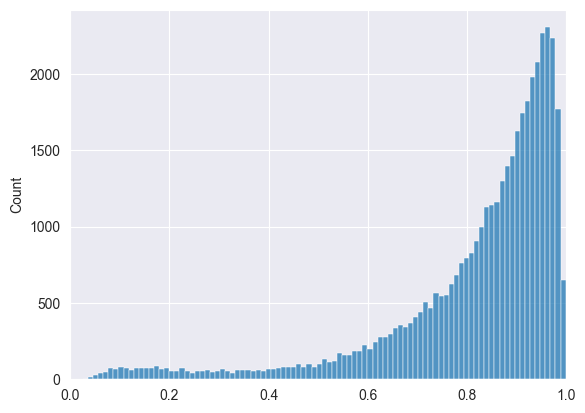

In [15]:
sns.histplot(oof)
plt.xlim(0.0, 1.0)
plt.show()

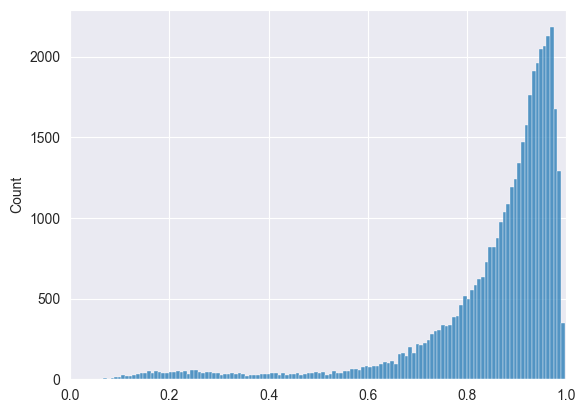

In [16]:
sns.histplot(pred_prob)
plt.xlim(0.0, 1.0)
plt.show()

### 予測値の1の割合を確認

In [25]:
print(pred_class.sum() / len(pred_class))

0.9347641108064668


### oofにおける混同行列を確認

True Negative Rate (0の正解率): 0.33
True Positive Rate (1の正解率): 0.96


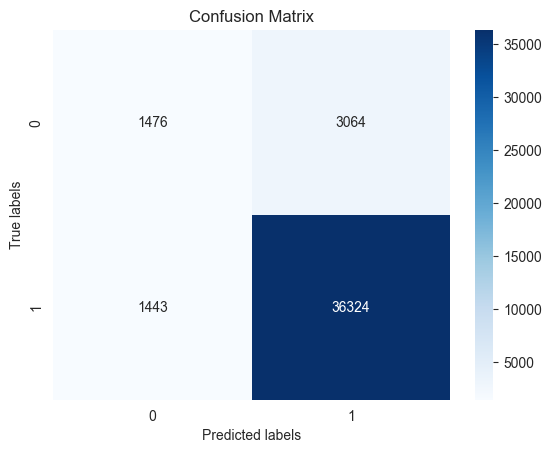

In [35]:
metrics.show_confusion_matrix(oof_truth, oof_hat)

## Submit

In [36]:
submit = submit.with_columns([pl.Series(cfg.Cols.sub_pred, pred_class)])
utils.make_submission(submit, exp, cv_score)